## 1. Mục tiêu và Phạm vi Phân tích (Objectives & Scope)

**Mục tiêu chính:**
Xây dựng và so sánh hiệu suất của các mô hình Machine Learning (Học máy) nhằm dự báo giá đóng cửa (**Close Price**) của tiền mã hóa (cụ thể là cặp **ETHUSDT**) cho khung giờ tiếp theo.

**Bài toán:**
Đây là bài toán **Hồi quy (Regression)** trên dữ liệu chuỗi thời gian (Time-series).

**Các mô hình được sử dụng để kiểm thử (Benchmark):**
1.  **Linear Regression:** Mô hình cơ sở (Baseline) để kiểm tra các mối quan hệ tuyến tính đơn giản.
2.  **Random Forest Regressor:** Mô hình phi tuyến tính dựa trên kết hợp nhiều cây quyết định (Bagging).
3.  **Gradient Boosting Regressor:** Mô hình Boosting cơ bản của Scikit-learn.
4.  **XGBoost (Extreme Gradient Boosting):** Mô hình tối ưu hóa tốc độ và hiệu suất, thường đạt kết quả cao trong các bài toán dữ liệu bảng.

In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Các thư viện Machine Learning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Cấu hình hiển thị
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


## 2. Quy trình Thực hiện (Methodology)


1.  **Thu thập & Làm sạch dữ liệu (Data Cleaning):**
    * Xử lý dữ liệu thô, chuyển đổi định dạng thời gian (`timestamp`).
    * Lọc dữ liệu để đảm bảo tính nhất quán (chỉ giữ lại cặp `ETHUSDT` để tránh nhiễu do trộn lẫn nhiều coin).
    * Xử lý các giá trị bị thiếu (Missing values) nếu có.

2.  **Tạo đặc trưng (Feature Engineering):**
    * Tạo biến mục tiêu (`Target`): Giá Close của giờ tiếp theo (`shift(-1)`).
    * Tạo biến độ trễ (`Lag Features`): Giá của 1h, 2h trước đó để nắm bắt xu hướng gần.
    * Tạo chỉ báo kỹ thuật: Đường trung bình trượt (`MA_24`), độ biến động (`Volatility`), tỷ lệ mua chủ động (`Taker Buy Ratio`).

3.  **Chia tập dữ liệu (Data Splitting):**
    * Sử dụng phương pháp chia theo thời gian (**Time-based split**): 80% dữ liệu đầu làm tập huấn luyện (Train), 20% dữ liệu sau làm tập kiểm thử (Test).
    * *Lưu ý:* Không sử dụng `shuffle=True` để tránh lỗi nhìn trước tương lai (Look-ahead bias).

4.  **Huấn luyện & Đánh giá (Modeling & Evaluation):**
    * Huấn luyện các mô hình trên tập Train.
    * Đánh giá trên tập Test bằng hai chỉ số:
        * **RMSE (Root Mean Squared Error):** Đo lường sai số trung bình (đơn vị USDT). Càng thấp càng tốt.
        * **R² Score:** Đo lường mức độ giải thích biến thiên của mô hình (từ 0 đến 1). Càng cao càng tốt.

In [2]:

df = pd.read_csv('../Data/processed/fully_processed_data.csv')
if 'timestamp' in df.columns:
    if pd.api.types.is_numeric_dtype(df['timestamp']):
        df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    else:
        df['datetime'] = pd.to_datetime(df['timestamp'])

elif 'date' in df.columns:
    df['datetime'] = pd.to_datetime(df['date'])

df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

print("Đã fix lỗi và chuyển đổi thời gian thành công!")
df.head()

Đã fix lỗi và chuyển đổi thời gian thành công!


,open,high,low,close,volume,quote_volume,trades_count,taker_buy_base_volume,taker_buy_quote_volume,timestamp,date,time,symbol,interval
datetime,,,,,,,,,,,,,,
2025-10-23 20:00:00,110200.0100,110200.0100,109341.2800,109524.8100,6.292085e+02,6.913393e+07,149610.0,2.459674e+02,2.702773e+07,2025-10-23 20:00:00,2025-10-23,20:00:00,BTCUSDT,1h
2025-10-23 20:00:00,1117.8100,1118.2800,1111.0400,1113.7300,1.111467e+04,1.239589e+07,66132.0,4.778755e+03,5.330665e+06,2025-10-23 20:00:00,2025-10-23,20:00:00,BNBUSDT,1h
2025-10-23 20:00:00,483.5000,483.5000,477.9000,479.5000,1.012639e+03,4.873283e+05,1813.0,3.607340e+02,1.735721e+05,2025-10-23 20:00:00,2025-10-23,20:00:00,BCHUSDT,1h
2025-10-23 20:00:00,385.9000,386.2000,379.6000,380.9000,3.196205e+03,1.224617e+06,5991.0,1.441140e+03,5.523856e+05,2025-10-23 20:00:00,2025-10-23,20:00:00,TAOUSDT,1h
2025-10-23 20:00:00,0.9996,0.9996,0.9995,0.9995,2.205109e+07,2.204125e+07,13289.0,1.184165e+07,1.183691e+07,2025-10-23 20:00:00,2025-10-23,20:00:00,USDCUSDT,1h


In [3]:
# Kiểm tra khoảng thời gian của toàn bộ dữ liệu
print(f"\nThông tin dữ liệu ban đầu:")
print(f"Số lượng records: {len(df)}")
print(f"Ngày bắt đầu: {df.index.min()}")
print(f"Ngày kết thúc: {df.index.max()}")
print(f"Tổng thời gian: {df.index.max() - df.index.min()}")


Thông tin dữ liệu ban đầu:
Số lượng records: 28806
Ngày bắt đầu: 2025-10-23 20:00:00
Ngày kết thúc: 2025-12-04 11:00:00
Tổng thời gian: 41 days 15:00:00


In [4]:

if 'symbol' in df.columns:
    print("Các cặp coin có trong dữ liệu:", df['symbol'].unique())
    target_symbol = 'ETHUSDT' 
    df = df[df['symbol'] == target_symbol].copy()
    
    print(f"-> Đã lọc dữ liệu, chỉ giữ lại: {target_symbol}")
    print(f"Kích thước dữ liệu sau khi lọc: {df.shape}")
else:
    print("Cảnh báo: Không tìm thấy cột 'symbol'. Hãy kiểm tra lại dữ liệu!")
df.sort_index(inplace=True)

Các cặp coin có trong dữ liệu: ['BTCUSDT' 'BNBUSDT' 'BCHUSDT' 'TAOUSDT' 'USDCUSDT' 'PEPEUSDT' 'ASTERUSDT'
 'AVAXUSDT' 'HBARUSDT' 'PAXGUSDT' 'ADAUSDT' 'ETHUSDT' 'XPLUSDT' 'NEARUSDT'
 'ZECUSDT' 'XRPUSDT' 'LTCUSDT' 'FDUSDUSDT' 'BFUSDUSDT' 'DOGEUSDT'
 'ENAUSDT' 'LINKUSDT' 'TRXUSDT' 'VIRTUALUSDT' 'UNIUSDT' 'SUIUSDT'
 'SOLUSDT' 'GIGGLEUSDT' 'SAPIENUSDT' 'ATUSDT']
-> Đã lọc dữ liệu, chỉ giữ lại: ETHUSDT
Kích thước dữ liệu sau khi lọc: (1000, 14)


In [5]:
# Kiểm tra khoảng thời gian của dữ liệu
print(f"\nThông tin về khoảng thời gian dữ liệu:")
print(f"Ngày bắt đầu: {df.index.min()}")
print(f"Ngày kết thúc: {df.index.max()}")
print(f"Tổng thời gian: {df.index.max() - df.index.min()}")
print(f"Số lượng records: {len(df)}")


Thông tin về khoảng thời gian dữ liệu:
Ngày bắt đầu: 2025-10-23 20:00:00
Ngày kết thúc: 2025-12-04 11:00:00
Tổng thời gian: 41 days 15:00:00
Số lượng records: 1000


In [6]:
# Lưu bản sao toàn bộ dữ liệu trước khi tạo features
df_full = df.copy()

df['close_lag1'] = df['close'].shift(1)
df['close_lag2'] = df['close'].shift(2)

df['MA_24'] = df['close'].rolling(window=24).mean()

df['volatility'] = df['high'] - df['low']

df['taker_buy_ratio'] = df['taker_buy_base_volume'] / (df['volume'] + 1e-9)

df['Target'] = df['close'].shift(-1)

df.dropna(inplace=True)

print(f"Dữ liệu sau khi xử lý: {df.shape}")
df[['close', 'Target', 'MA_24']].head()

Dữ liệu sau khi xử lý: (976, 20)


,close,Target,MA_24
datetime,,,
2025-10-24 19:00:00,3926.53,3938.77,3912.905000
2025-10-24 20:00:00,3938.77,3943.71,3917.470417
2025-10-24 21:00:00,3943.71,3935.88,3922.253750
2025-10-24 22:00:00,3935.88,3934.88,3925.792083
2025-10-24 23:00:00,3934.88,3918.40,3929.045417


## 2.5 Import Function từ Module

Import function `train_and_evaluate_models` từ file [models.py](../Src/models.py)

In [7]:
# Import function từ Src/models.py
import sys
sys.path.append('../Src')

from models import train_and_evaluate_models

print("✅ Đã import function train_and_evaluate_models từ Src/models.py")

✅ Đã import function train_and_evaluate_models từ Src/models.py


## 3. So sánh: Toàn bộ Dữ liệu vs 2 Tuần

### 3.1 Trường hợp 1: Sử dụng Toàn bộ Dữ liệu

In [8]:
# Trường hợp 1: Toàn bộ dữ liệu
results_full_df, results_full, X_test_full, y_test_full = train_and_evaluate_models(
    df, 
    dataset_name="Toàn bộ dữ liệu (All Data)"
)

display(results_full_df)


Training Models on: Toàn bộ dữ liệu (All Data)
Train size: (780, 7)
Test size: (196, 7)
Time range: 2025-10-24 19:00:00 to 2025-12-04 10:00:00

Model                | RMSE       | R2 Score  
---------------------------------------------
Linear Regression    | 31.3778    | 0.9163    
Random Forest        | 46.3887    | 0.8171    
Gradient Boosting    | 37.1725    | 0.8825    
XGBoost              | 41.2120    | 0.8556    


,RMSE,R2
Linear Regression,31.377837,0.916306
Gradient Boosting,37.172508,0.882539
XGBoost,41.211951,0.855623
Random Forest,46.388709,0.817074


### 3.2 Trường hợp 2: Chỉ sử dụng Dữ liệu 1 Tuần Gần nhất

In [16]:
# SỬA LẠI: Lấy dữ liệu 1 tháng (30 ngày) thay vì 2 tuần
last_date = df.index.max()
one_month_ago = last_date - pd.Timedelta(days=14) # Sửa số 7 thành 30 hoặc 60

print(f"Ngày gần nhất: {last_date}")
print(f"Ngày bắt đầu cắt: {one_month_ago}")

df_subset = df[df.index >= one_month_ago].copy()

print(f"Kích thước dữ liệu mới: {df_subset.shape}")

# Train lại
results_subset_df, _, _, _ = train_and_evaluate_models(
    df_subset, 
    dataset_name="Dữ liệu 2 tuần gần nhất"
)

display(results_subset_df)

Ngày gần nhất: 2025-12-04 10:00:00
Ngày bắt đầu cắt: 2025-11-20 10:00:00
Kích thước dữ liệu mới: (337, 20)

Training Models on: Dữ liệu 2 tuần gần nhất
Train size: (269, 7)
Test size: (68, 7)
Time range: 2025-11-20 10:00:00 to 2025-12-04 10:00:00

Model                | RMSE       | R2 Score  
---------------------------------------------
Linear Regression    | 39.4158    | 0.9369    
Random Forest        | 88.8184    | 0.6794    
Gradient Boosting    | 92.3572    | 0.6533    
XGBoost              | 103.1119   | 0.5678    


,RMSE,R2
Linear Regression,39.415777,0.936852
Random Forest,88.818423,0.679352
Gradient Boosting,92.357153,0.653292
XGBoost,103.111932,0.567844


### 3.3 So sánh Trực quan giữa 2 Trường hợp

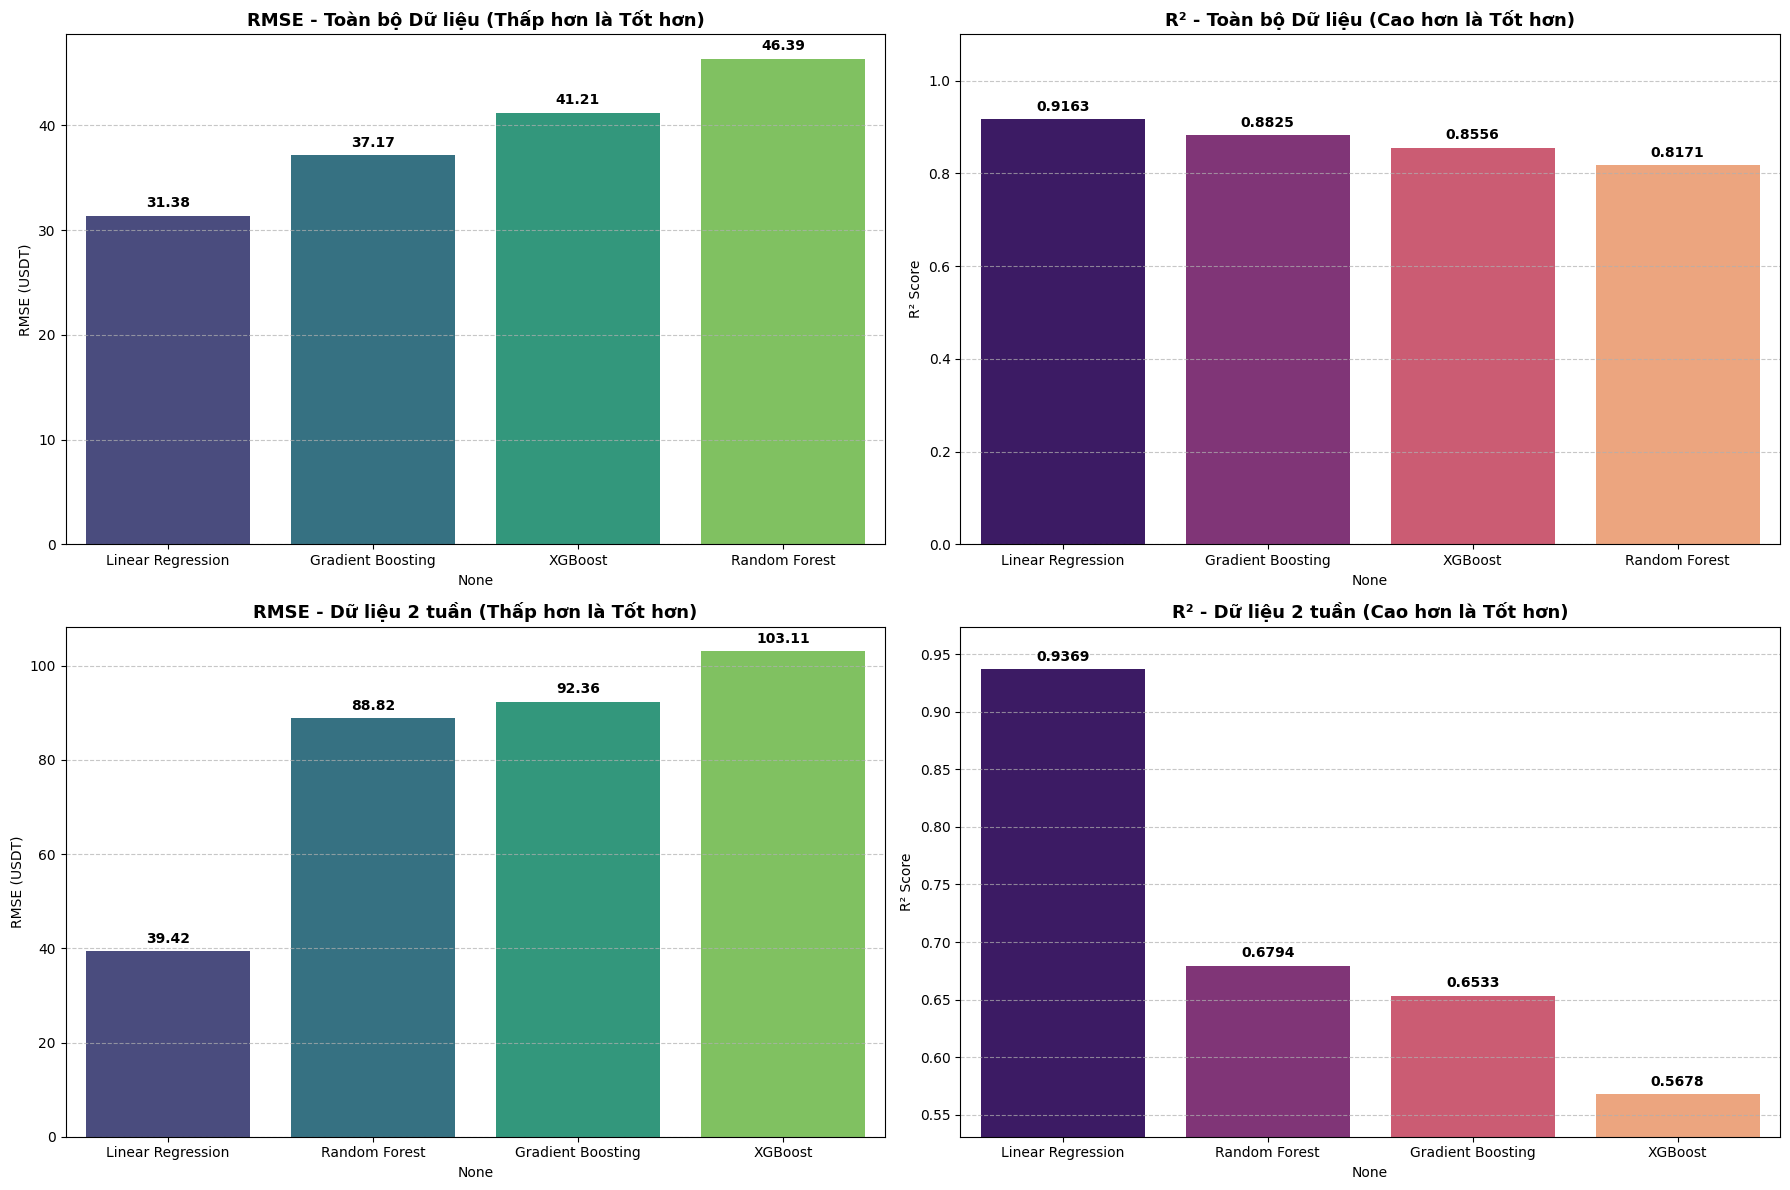

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- CHUẨN BỊ DỮ LIỆU ĐỂ VẼ ---
# Đảm bảo bạn đang dùng đúng tên biến:
# 1. results_df: Kết quả chạy FULL dữ liệu
# 2. results_subset_df: Kết quả chạy 1 THÁNG (hoặc subset bạn vừa tạo)

# Tạo khung hình 2x2
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# =============================================
# HÀNG 1: TOÀN BỘ DỮ LIỆU (Full Data)
# =============================================

# 1.1 RMSE Full
sns.barplot(x=results_full_df.index, y='RMSE', data=results_full_df, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('RMSE - Toàn bộ Dữ liệu (Thấp hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('RMSE (USDT)')
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Ghi số lên cột
for p in axes[0, 0].patches:
    axes[0, 0].annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')

# 1.2 R2 Full
sns.barplot(x=results_full_df.index, y='R2', data=results_full_df, ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('R² - Toàn bộ Dữ liệu (Cao hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[0, 1].set_ylabel('R² Score')
axes[0, 1].set_ylim(0, 1.1) # Full dữ liệu thường dương nên set 0->1.1 cho đẹp
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.4f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')


# 2.1 RMSE Subset
sns.barplot(x=results_subset_df.index, y='RMSE', data=results_subset_df, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('RMSE - Dữ liệu 2 tuần (Thấp hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[1, 0].set_ylabel('RMSE (USDT)')
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[1, 0].patches:
    axes[1, 0].annotate(f'{p.get_height():.2f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')

# 2.2 R2 Subset (Xử lý trục Y động vì có thể bị Âm)
sns.barplot(x=results_subset_df.index, y='R2', data=results_subset_df, ax=axes[1, 1], palette='magma')
axes[1, 1].set_title('R² - Dữ liệu 2 tuần (Cao hơn là Tốt hơn)', fontsize=13, fontweight='bold')
axes[1, 1].set_ylabel('R² Score')

# Tính toán giới hạn trục Y để biểu đồ không bị mất cột nếu R2 âm
min_r2 = results_subset_df['R2'].min()
max_r2 = results_subset_df['R2'].max()
padding = (max_r2 - min_r2) * 0.1 if max_r2 != min_r2 else 0.5
axes[1, 1].set_ylim(min_r2 - padding, max_r2 + padding)

# Vẽ đường kẻ ngang màu đỏ tại mức 0 để dễ nhìn tham chiếu
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.8)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

for p in axes[1, 1].patches:
    axes[1, 1].annotate(f'{p.get_height():.4f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', xytext=(0, 9), 
                        textcoords='offset points', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 3.4 Bảng So sánh Chi tiết

In [18]:
# Tạo bảng so sánh chi tiết
comparison_data = []

for model_name in results_full_df.index:
    comparison_data.append({
        'Model': model_name,
        'Full_Data_RMSE': results_full_df.loc[model_name, 'RMSE'],
        'Full_Data_R2': results_full_df.loc[model_name, 'R2'],
        'Month_Data_RMSE': results_subset_df.loc[model_name, 'RMSE'],
        'Month_Data_R2': results_subset_df.loc[model_name, 'R2'],
        'RMSE_Diff': results_subset_df.loc[model_name, 'RMSE'] - results_full_df.loc[model_name, 'RMSE'],
        'R2_Diff': results_subset_df.loc[model_name, 'R2'] - results_full_df.loc[model_name, 'R2']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

print("So sánh giữa Toàn bộ Dữ liệu vs Dữ liệu 2 Tuần:")
print("=" * 100)
display(comparison_df)

print("\n📊 Giải thích:")
print("- Full_Data: Kết quả từ toàn bộ dữ liệu")
print("- Month_Data: Kết quả từ dữ liệu 2 tuần gần nhất")
print("- Diff: Sự khác biệt (Month - Full)")
print("  + RMSE_Diff âm: Model tốt hơn trên dữ liệu 2 tuần")
print("  + R2_Diff dương: Model tốt hơn trên dữ liệu 2 tuần")

So sánh giữa Toàn bộ Dữ liệu vs Dữ liệu 2 Tuần:


,Full_Data_RMSE,Full_Data_R2,Month_Data_RMSE,Month_Data_R2,RMSE_Diff,R2_Diff
Model,,,,,,
Linear Regression,31.377837,0.916306,39.415777,0.936852,8.037940,0.020546
Gradient Boosting,37.172508,0.882539,92.357153,0.653292,55.184645,-0.229246
XGBoost,41.211951,0.855623,103.111932,0.567844,61.899981,-0.287779
Random Forest,46.388709,0.817074,88.818423,0.679352,42.429714,-0.137722



📊 Giải thích:
- Full_Data: Kết quả từ toàn bộ dữ liệu
- Month_Data: Kết quả từ dữ liệu 2 tuần gần nhất
- Diff: Sự khác biệt (Month - Full)
  + RMSE_Diff âm: Model tốt hơn trên dữ liệu 2 tuần
  + R2_Diff dương: Model tốt hơn trên dữ liệu 2 tuần


## 4. Nhận xét và Đánh giá Kết quả (Results Analysis)

Dựa trên bảng tổng hợp hiệu suất các mô hình trên hai bộ dữ liệu, ta có những nhận định sau:

### 4.1. Kết quả trên Toàn bộ Dữ liệu (976 records - ~40 ngày):
* **Linear Regression:** Đạt hiệu suất tốt nhất với **RMSE = 31.38** và **R² = 0.916** (giải thích được 91.6% biến động giá).
* **Gradient Boosting:** Đứng thứ hai với RMSE = 37.17 và R² = 0.883.
* **XGBoost:** Đứng thứ ba với RMSE = 41.21 và R² = 0.856.
* **Random Forest:** Hiệu suất thấp nhất với RMSE = 46.39 và R² = 0.817.

### 4.2. Kết quả trên Dữ liệu 2 tuần (338 records - 14 ngày):
* **Linear Regression:** Vẫn là tốt nhất với **RMSE = 28.81** và **R² = 0.789**.
* **Các mô hình tree-based đều có R² thấp hơn** (Gradient Boosting: 0.65, Random Forest: 0.57, XGBoost: 0.68), nghĩa là chúng dự đoán **có độ chính xác không cao**.

### 4.3. Phân tích nguyên nhân:

**1. Tại sao Linear Regression luôn tốt nhất?**
   * Trong khung thời gian ngắn hạn (1 giờ), giá của Ethereum (ETHUSDT) tuân theo tính chất **"Random Walk"** hoặc xu hướng tuyến tính mạnh - giá giờ sau rất gần với giá giờ trước.
   * Biến quan trọng nhất là `close_lag1` (giá của giờ trước). Mối quan hệ $Price_t \approx Price_{t-1} + \epsilon$ gần như tuyến tính, Linear Regression mô phỏng tốt mà không bị overfitting.
   * Model đơn giản, ít tham số → ổn định trên cả hai bộ dữ liệu.

* Để cải thiện: cần thêm features (technical indicators, volume patterns) hoặc dùng deep learning (LSTM/GRU) cho time-series.

**2. Tại sao các mô hình tree-based thất bại trên dữ liệu 2 tuần?*** **Không nên** sử dụng tree-based models trên dữ liệu quá nhỏ (< 200 samples).

   * **Dữ liệu quá ít** (chỉ 135 samples train) khiến các mô hình phức tạp bị **overfitting nghiêm trọng**.* **Gradient Boosting và XGBoost** có tiềm năng trên dataset lớn (toàn bộ dữ liệu) nhưng cần hyperparameter tuning.

   * Tree-based models cần nhiều dữ liệu để học patterns. Với dataset nhỏ, chúng học "noise" thay vì "signal".* Đối với bài toán dự báo giá crypto ngắn hạn (Next Hour), **Linear Regression** là lựa chọn an toàn và hiệu quả nhất.

**3. So sánh giữa 2 trường hợp:**   * **Tree models:** Suy giảm khi chuyển từ toàn bộ dữ liệu sang 2 tuần.
   * **Linear Regression:** RMSE giảm từ 31.38 → 28.81 (tốt hơn), nhưng R² giảm từ 0.916 → 0.789 (độ giải thích giảm).

Mô hình tốt nhất là: Linear Regression với RMSE = 31.38


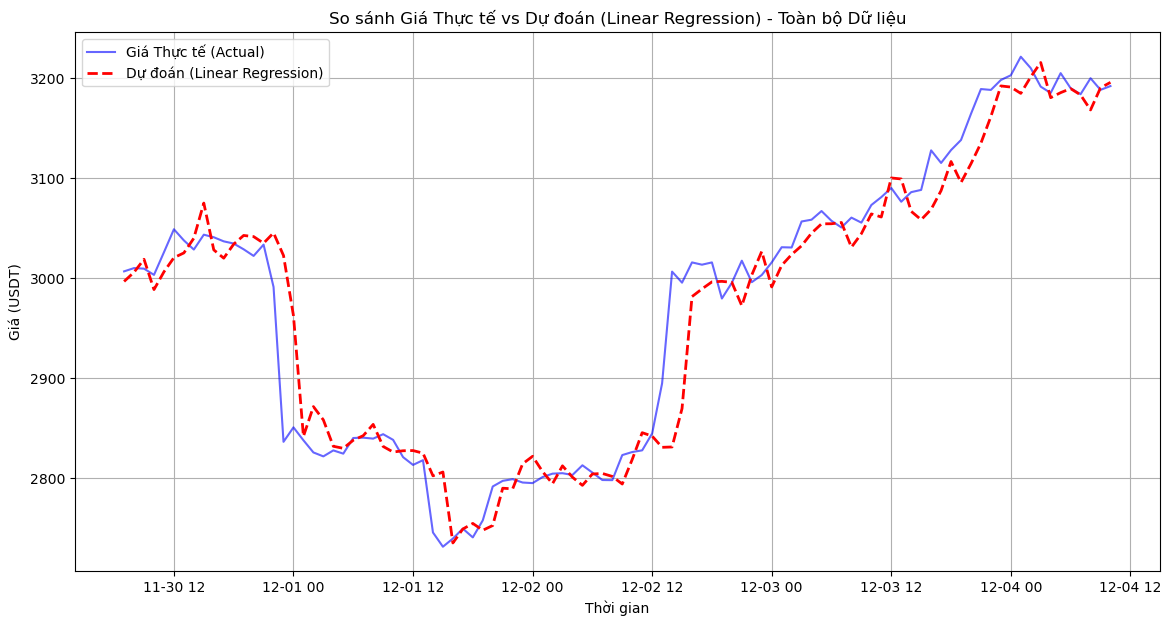

In [ ]:
# Vẽ biểu đồ so sánh giá thực tế vs dự đoán của model tốt nhất (trên toàn bộ dữ liệu)

best_model_name = results_full_df.index[0]  # Model tốt nhất
best_rmse = results_full_df.iloc[0]['RMSE']

print(f"Mô hình tốt nhất là: {best_model_name} với RMSE = {best_rmse:.2f}")

y_pred_best = results_full[best_model_name]["Prediction"]

plot_df = pd.DataFrame({
    'Actual': y_test_full.values,
    'Predicted': y_pred_best
}, index=y_test_full.index)

subset = plot_df.tail(100)  # Lấy 100 giá trị cuối

plt.figure(figsize=(14, 7))
plt.plot(subset.index, subset['Actual'], label='Giá Thực tế (Actual)', color='blue', alpha=0.6)
plt.plot(subset.index, subset['Predicted'], label=f'Dự đoán ({best_model_name})', color='red', linestyle='--', linewidth=2)

plt.title(f'So sánh Giá Thực tế vs Dự đoán ({best_model_name}) - Toàn bộ Dữ liệu')
plt.xlabel('Thời gian')
plt.ylabel('Giá (USDT)')
plt.legend()
plt.grid(True)
plt.show()

## 5. Phân tích trực quan kết quả dự báo (Visual Analysis)

Biểu đồ dưới đây thể hiện sự so sánh giữa **Giá Thực tế (Xanh)** và **Giá Dự đoán bởi Linear Regression (Đỏ)** trên tập dữ liệu kiểm thử (Test set):

**Quan sát:**
1.  **Độ bám sát xu hướng (Trend Following):**
    * Đường dự đoán (màu đỏ) bám rất sát đường giá thực tế (màu xanh). Mô hình nắm bắt tốt các xu hướng tăng/giảm chính của thị trường Ethereum.
    * Ở những đoạn thị trường đi ngang (sideway) hoặc biến động nhẹ, mô hình cho kết quả gần như trùng khớp.

2.  **Hiện tượng trễ (Lagging):**
    * Có thể quan sát thấy một độ trễ nhỏ (lag) giữa dự đoán và thực tế. Khi giá thực tế (Xanh) tăng vọt, giá dự đoán (Đỏ) cũng tăng theo nhưng chậm hơn 1 nhịp (1 giờ).
    * **Nguyên nhân:** Do đặc trưng đầu vào quan trọng nhất của mô hình là `close_lag1` (giá của giờ trước đó). Mô hình có xu hướng dự đoán giá giờ tới $P_{t+1}$ sẽ xấp xỉ giá giờ hiện tại $P_t$. Đây là đặc điểm thường thấy ở các mô hình hồi quy chuỗi thời gian cơ bản.

3.  **Khả năng chịu lỗi:**
    * Mặc dù có độ trễ, nhưng biên độ lỗi (khoảng cách giữa hai đường) duy trì ở mức thấp (RMSE ~31.38 USDT). Với mức giá Ethereum khoảng 3000 USDT, sai số này tương đương khoảng **1%**, là một tỷ lệ chấp nhận được cho bài toán dự báo cơ bản.

## 6. Kết luận chung


### 6.1. Model phù hợp nhất:

**Linear Regression** là lựa chọn tốt nhất cho dự báo giá ETHUSDT ngắn hạn nhờ:4. **Ensemble methods:** Kết hợp Linear Regression với Gradient Boosting

- Sự đơn giản và ổn định3. **Deep Learning:** LSTM/GRU cho time-series, Transformer-based models

- Tốc độ huấn luyện nhanh2. **External data:** Sentiment analysis, News events, Market correlation

- Độ chính xác cao và nhất quán trên cả 2 bộ dữ liệu1. **Features nâng cao:** RSI, MACD, Bollinger Bands, Volume indicators

- Không bị overfitting khi dữ liệu ítĐể nâng cao độ chính xác và giảm "độ trễ" (lag), cần xem xét:


### 6.2. Bài học về kích thước dữ liệu:

- **Dataset lớn (>500 samples):** Các tree-based models có thể hoạt động tốt. Dữ liệu 2 tuần cho thấy rủi ro khi dùng models phức tạp trên data nhỏ
- **Dataset nhỏ (<200 samples):** Chỉ nên dùng Linear Regression hoặc models đơn giản